### Imports, initialization of constants, general set up

In [8]:
import json
import os
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

DATASETS = ["cacm", "med", "npl"]
TREC_EVAL_COMMAND = "trec_eval"

### Functions for evaluating results

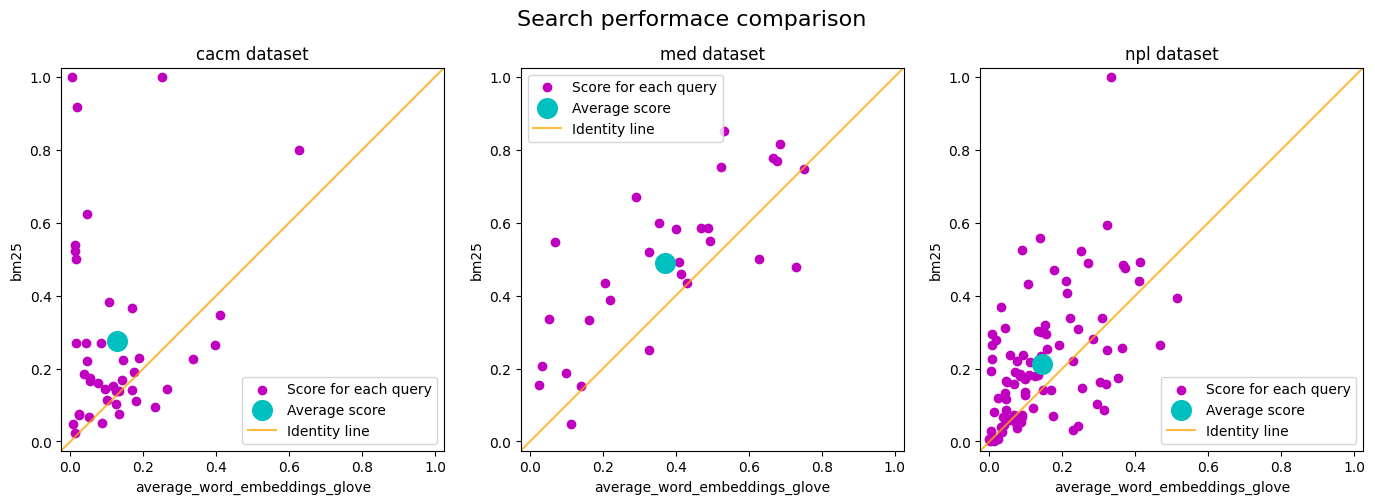

In [37]:
def compare_results_scatter_plot(result_file_names, axis_descriptions, fig_filename=""):
    figure, axis = plt.subplots(1, 3, figsize=(14, 5))
    for i, dataset in enumerate(DATASETS):
        x = pd.read_csv(result_file_names[0] % dataset, sep="\t", header=None).sort_values(by=[1])[2].to_numpy()
        y = pd.read_csv(result_file_names[1] % dataset, sep="\t", header=None).sort_values(by=[1])[2].to_numpy()
        axis[i].set_aspect(1)
        axis[i].scatter(x[:-1], y[:-1], c="m", label="Score for each query")
        axis[i].scatter(x[-1], y[-1], s=[200], c="c", label="Average score")
        axis[i].plot(np.linspace(-0.025, 1.025), np.linspace(-0.025, 1.025), label="Identity line", c="orange", alpha=0.75)
        axis[i].set_xlim(-0.025, 1.025)
        axis[i].set_ylim(-0.025, 1.025)
        axis[i].set_xlabel(axis_descriptions[0])
        axis[i].set_ylabel(axis_descriptions[1])
        axis[i].set_title(f"{dataset} dataset")
        axis[i].legend()
    
    plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.91)
    figure.suptitle(f"Search performace comparison", fontsize=16)
    if fig_filename:
        plt.savefig(fig_filename, dpi=300)
    plt.show()

def bar_chart(df_list_one, df_list_two, names,legend_names,barchart_name,y_axe_name):
    # Create a data frame with the values and names
    df = pd.DataFrame({'values_one': df_list_one, 'values_two': df_list_two, 'names': names})

    # Set the bar width
    bar_width = 0.4

    # Calculate the x-coordinates for the bars
    x = range(len(df))

    # Create the plot
    fig, ax = plt.subplots()
    ax.bar(x, df['values_one'], width=bar_width, label=legend_names[0], color='m')
    ax.bar([i + bar_width for i in x], df['values_two'], width=bar_width, label=legend_names[1], color='c')
    ax.set_ylabel(y_axe_name)
    ax.set_title(barchart_name)
    ax.set_xticks([i + bar_width / 2 for i in x], df['names'])
    ax.legend()

    plt.show()

def plot_bar_chart(input_files_one,input_files_two,names_of_datasets,legend_names,barchart_name,y_axe_name):
    # Create an empty list to store the data frames
    df_list_one = []
    df_list_two = []

    # Iterate over the input files
    for file in input_files_one:
        # Read the file into a data frame
        df = pd.read_csv(file, sep='\t', names=['map', 'index', 'value'])

        # Extract the rows with the 'all' index
        df_all = df[df['index'] == 'all']
        value = df_all['value'].iloc[0]
        # Add the data frame to the list
        df_list_one.append(value)

    for file in input_files_two:
        # Read the file into a data frame
        df = pd.read_csv(file, sep='\t', names=['map', 'index', 'value'])

        # Extract the rows with the 'all' index
        df_all = df[df['index'] == 'all']
        value = df_all['value'].iloc[0]
        # Add the data frame to the list
        df_list_two.append(value)


    bar_chart(df_list_one,df_list_two, names_of_datasets, legend_names, barchart_name, y_axe_name)

## Reference
We chose the BM-25 search as our reference fro all tasks.

In [10]:
for dataset in DATASETS:
    # indexing documents
    os.system(f"python3 bm25_index.py -f ./data/{dataset}/{dataset}.json -i bm25_{dataset} -v 0")
    
    # running search on the indexed documents using queries converted to embeddings
    os.system(f"python3 bm25_search.py -q ./data/{dataset}/queries.json -i bm25_{dataset} -o ./bm25_reference/outputs/bm25_{dataset}.txt")
    
    # evaluating the search results with trec_eval
    os.system(f"{TREC_EVAL_COMMAND} -m map -q ./data/{dataset}/qrels-treceval.txt ./bm25_reference/outputs/bm25_{dataset}.txt > ./bm25_reference/results/map_bm25_{dataset}.txt")

./data/cacm/cacm.json is already indexed and has the name: bm25_cacm
To delete use following command: 
curl -X DELETE "localhost:9200/bm25_cacm"
./data/med/med.json is already indexed and has the name: bm25_med
To delete use following command: 
curl -X DELETE "localhost:9200/bm25_med"
./data/npl/npl.json is already indexed and has the name: bm25_npl
To delete use following command: 
curl -X DELETE "localhost:9200/bm25_npl"


## Task 01
In this task we use Google Pegasus to summarize the data and compare the results of the unsummarized and summarized using BM-25.

In [11]:
#Adjust this array for all possible json-files
#Json file and folder name has to be the same

DATA_SETS = ["med", "cacm", "npl"]
os.makedirs("./outputs", exist_ok=True)
os.makedirs("./results", exist_ok=True)

print("----------------------------------------------------------")
print("Summarize datasets")
print("----------------------------------------------------------")
for data in DATA_SETS:
    os.system(f"python3 summarize_data.py {data}")
    print()
print("----------------------------------------------------------")
print("Index datasets in elasticsearch")
print("----------------------------------------------------------")
for data in DATA_SETS:
    os.system(f"python3 ../bm25_index.py ../data/{data}/{data}.json {data}")
    print()
    os.system(f"python3 ../bm25_index.py ../data/{data}/{data}_summarize_en.json {data}_summarize_en")
    print()
print("----------------------------------------------------------")
print("Search using bm25")
print("----------------------------------------------------------")\

for data in DATA_SETS:
    os.system(f"python3 ../bm25_search.py ../data/{data}/queries.json {data} > ./outputs/{data}_bm25.txt")
    print(f"Search for index {data} is done... ")
    os.system(f"python3 ../bm25_search.py ../data/{data}/queries.json {data}_summarize_en > ./outputs/{data}_summarize_en_bm25.txt")
    print(f"Search for index {data}_summarize_en is done... ")

print("----------------------------------------------------------")
print("Using trec-eval for evaluation")
print("----------------------------------------------------------")
for data in DATA_SETS:
    os.system(f"trec_eval -m map -q ../data/{data}/qrels-treceval.txt ./outputs/{data}_bm25.txt > ./results/{data}_bm25.txt")
    print(f"Trec eval  {data} is done... ")
    os.system(f"trec_eval -m map -q ../data/{data}/qrels-treceval.txt ./outputs/{data}_summarize_en_bm25.txt > ./results/{data}_summarize_en_bm25.txt")
    print(f"Trec eval  {data} is done... ")
print("----------------------------------------------------------")
print("Task 01 is done")
print("----------------------------------------------------------")

----------------------------------------------------------
Summarize datasets
----------------------------------------------------------



----------------------------------------------------------
Index datasets in elasticsearch
----------------------------------------------------------






----------------------------------------------------------
Search using bm25
----------------------------------------------------------
Search for index med is done... 
Search for index med_summarize_en is done... 
Search for index cacm is done... 
Search for index cacm_summarize_en is done... 
Search for index npl is done... 
Search for index npl_summarize_en is done... 
----------------------------------------------------------
Using trec-eval for evaluation
----------------------------------------------------------
Trec eval  med is done... 
Trec eval  med is done... 
Trec eval  cacm is done... 
Trec eval  cacm is done... 
Trec eval  npl is done... 
Trec eval  npl is done... 
----------------

python3: can't open file '/home/david/projs/air_proj/summarize_data.py': [Errno 2] No such file or directory
python3: can't open file '/home/david/projs/air_proj/summarize_data.py': [Errno 2] No such file or directory
python3: can't open file '/home/david/projs/air_proj/summarize_data.py': [Errno 2] No such file or directory
python3: can't open file '/home/david/projs/air_proj/../bm25_index.py': [Errno 2] No such file or directory
python3: can't open file '/home/david/projs/air_proj/../bm25_index.py': [Errno 2] No such file or directory
python3: can't open file '/home/david/projs/air_proj/../bm25_index.py': [Errno 2] No such file or directory
python3: can't open file '/home/david/projs/air_proj/../bm25_index.py': [Errno 2] No such file or directory
python3: can't open file '/home/david/projs/air_proj/../bm25_index.py': [Errno 2] No such file or directory
python3: can't open file '/home/david/projs/air_proj/../bm25_index.py': [Errno 2] No such file or directory
python3: can't open file 

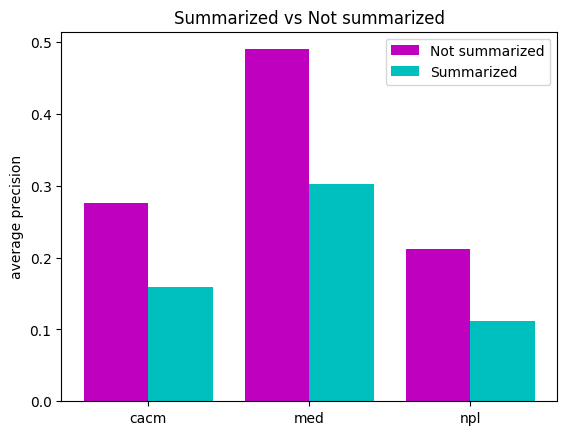

In [12]:
plot_bar_chart(["./task_01/results/cacm_bm25.txt", "./task_01/results/med_bm25.txt","./task_01/results/npl_bm25.txt"],
               ["./task_01/results/cacm_summarize_en_bm25.txt", "./task_01/results/med_summarize_en_bm25.txt","./task_01/results/npl_summarize_en_bm25.txt"],
               ["cacm", "med", "npl"],
               ["Not summarized", "Summarized"],
               "Summarized vs Not summarized",
               "average precision")

TypeError: not all arguments converted during string formatting

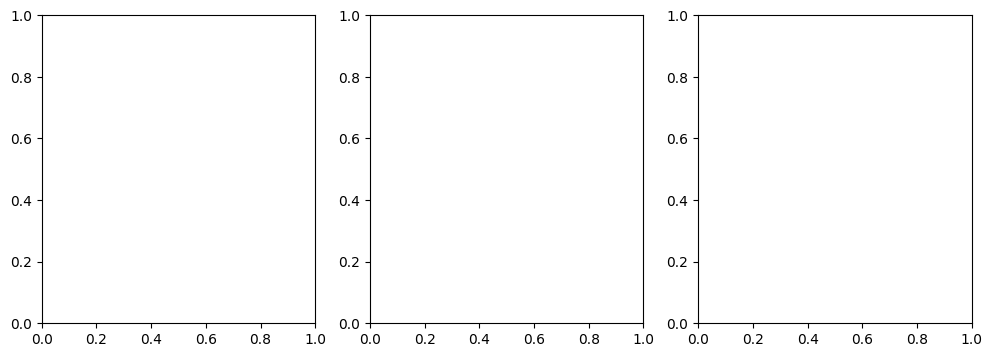

In [13]:
#Results of cacm
compare_results_scatter_plot(["./task_01/results/cacm_bm25.txt", "./task_01/results/cacm_summarize_en_bm25.txt"], ["cacm_bm25", "cacm_summarize_bm25"])

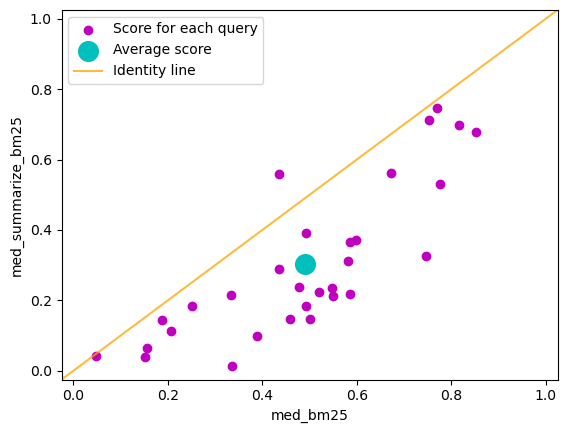

In [ ]:
#Results of med
compare_results_scatter_plot(["./task_01/results/med_bm25.txt", "./task_01/results/med_summarize_en_bm25.txt"], ["med_bm25", "med_summarize_bm25"])

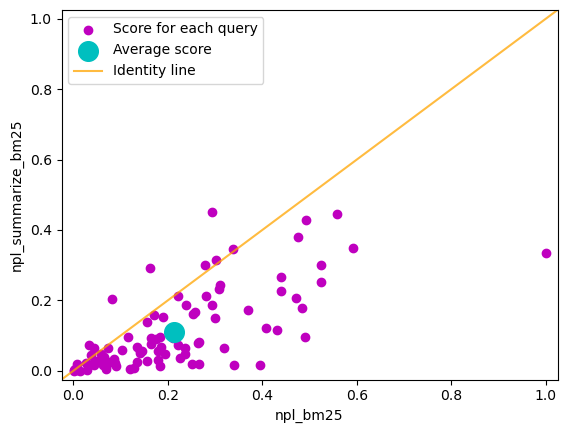

In [ ]:
#Results of npl
compare_results_scatter_plot(["./task_01/results/npl_bm25.txt", "./task_01/results/npl_summarize_en_bm25.txt"], ["npl_bm25", "npl_summarize_bm25"])

## Task 02
In this task we compared BM-25 search with cosine similarity search using embeddings created by different sentence transformers.

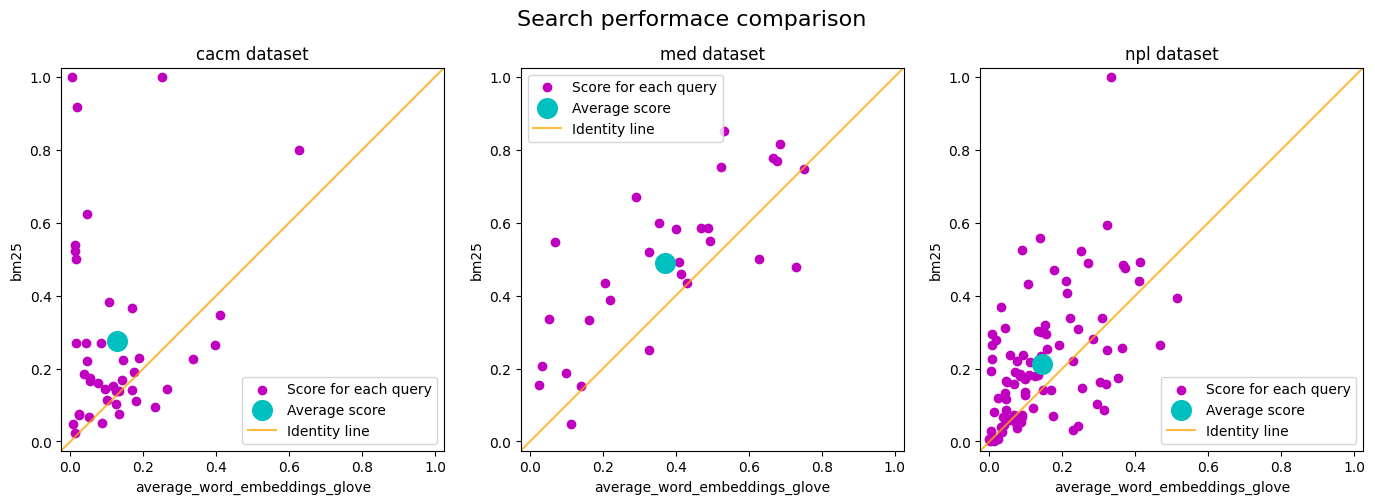

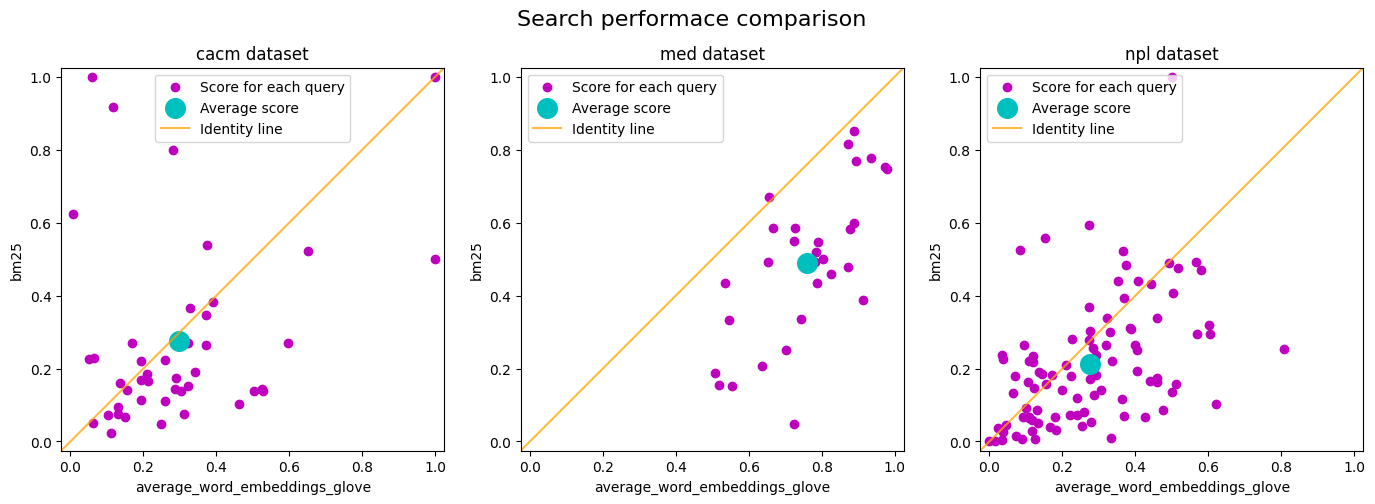

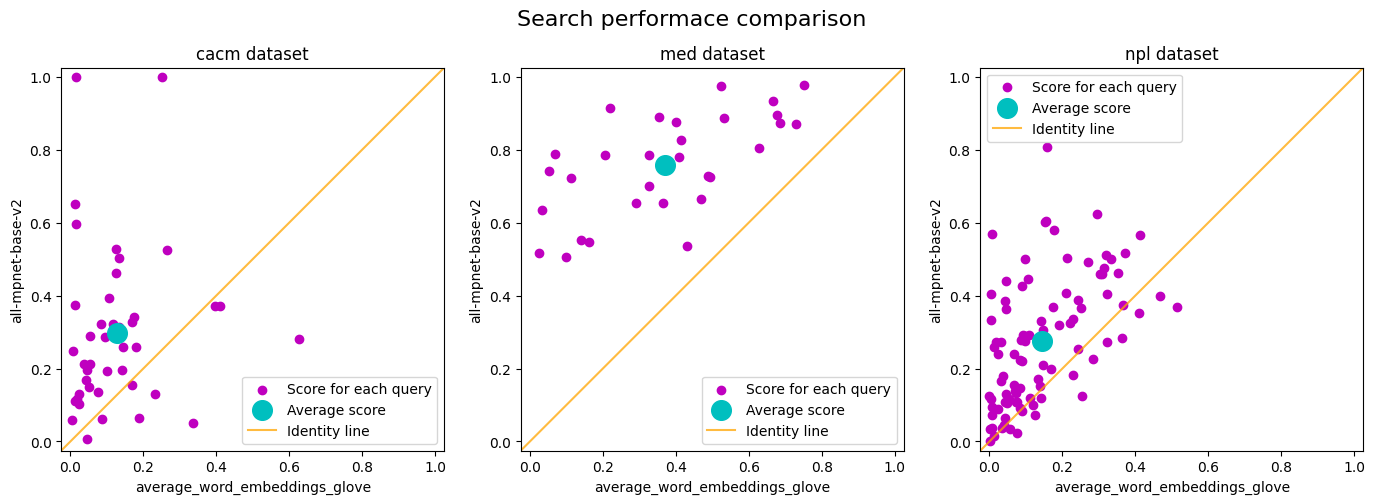

In [38]:

MODEL_SHORTCUTS = ["glove", "minil6", "minil12", "mpnetv2"]
MODEL_NAMES = ["average_word_embeddings_glove.6B.300d", "all-MiniLM-L6-v2", "all-MiniLM-L12-v2", "all-mpnet-base-v2"]

for dataset in DATASETS:
    for model_name, model_shortcut in zip(MODEL_NAMES, MODEL_SHORTCUTS):
        # indexing documents from a data set converted to embeddings into elasticsearch
        os.system(f"python3 embedding_index.py -f ./data/{dataset}/{dataset}.json -i {model_shortcut}_{dataset} -m {model_name} -v 0")
        
        # running search on the indexed documents using queries converted to embeddings
        os.system(f"python3 embedding_search.py -q ./data/{dataset}/queries.json -i {model_shortcut}_{dataset} -m {model_name} -o ./task_02/outputs/{model_shortcut}_{dataset}.txt")
        
        # evaluating the search results with trec_eval
        os.system(f"{TREC_EVAL_COMMAND} -m map -q ./data/{dataset}/qrels-treceval.txt ./task_02/outputs/{model_shortcut}_{dataset}.txt > ./task_02/results/map_{model_shortcut}_{dataset}.txt")

# glove vs BM-25
compare_results_scatter_plot(["./task_02/results/map_glove_%s.txt", "./bm25_reference/results/map_bm25_%s.txt"], ["average_word_embeddings_glove", "bm25"], "presentation/figures/glove_vs_bm25")

# mpnetv2 vs BM-25
compare_results_scatter_plot(["./task_02/results/map_mpnetv2_%s.txt", "./bm25_reference/results/map_bm25_%s.txt"], ["average_word_embeddings_glove", "bm25"], "presentation/figures/mpnetv2_vs_bm25")

# glove vs mpnetv2
compare_results_scatter_plot(["./task_02/results/map_glove_%s.txt", "./task_02/results/map_mpnetv2_%s.txt"], ["average_word_embeddings_glove", "all-mpnet-base-v2"], "presentation/figures/glove_vs_mpnetv2")

## Task 04
In this task we fine-tuned pre-trained multilingual sentence transformers and evaluated its performance on queries in different languages.

In [ ]:
# sentence transformers models
MODELS = [
    "paraphrase-multilingual-MiniLM-L12-v2", "distiluse-base-multilingual-cased-v1",
    "paraphrase-multilingual-mpnet-base-v2"
]
MODEL_SHORTCUTS = ["ml_miniLM_L12_v2", "dbmlc_v1", "ml_mpnet_base_v2"]

LANGUAGES = ["EN", "DE"]
# ? Italian and Czech
# LANGUAGES = ["EN", "DE", "IT", "CS"]

# model fine-tuning parameters
MODEL_FOLDER = f"./task_04/models"
EPOCHS = 1
WARMUP_STEPS = 500
BATCH_SIZE = 16

for dataset in DATASETS:
    for model, model_shortcut in zip(MODELS, MODEL_SHORTCUTS):
        # translate queries to target language
        for language in LANGUAGES:
            os.system(  # see translate.py regarding DeepL API key
                f"python3 translate.py -l EN -s ./data/{dataset}/queries.json -t ./data/{dataset}/queries_{language}.json -d ./deepl_auth.key"
            )

        model_path = f"{MODEL_PATH}/{dataset}_{model_shortcut}/"

        # fine-tune models on the data set
        model_path = f"{MODEL_FOLDER}/{model_shortcut}_{dataset}/"
        print(f"Fine-tuning {model} on {dataset}...")
        os.system(
            f"python3 finetune.py -m {model} -d ./data/{dataset}/{dataset}.json -f {model_path} -e {EPOCHS} -w {WARMUP_STEPS} -b {BATCH_SIZE}"
        )

        # convert documents to embeddings and create index in ElasticSearch
        print(f"Embedding docs and creating index for {dataset}...")
        index = f"{model_shortcut.lower()}_{dataset}_fine_tuned"
        os.system(
            f"python3 embedding_index.py -f ./data/{dataset}/{dataset}.json -i {index} -m {model_path} -v 0"
        )

        # search on indexed documents using queries in target languages
        for language in LANGUAGES:
            print(f"Searching for {language} queries in {dataset}...")
            os.system(
                f"python3 embedding_search.py -q ./data/{dataset}/queries_{language}.json -i {index} -m {model_path} -o ./task_04/outputs/{model_shortcut}_{dataset}_{language}.txt"
            )

            # evaluating the search results with trec_eval
            print(f"Evaluating {model_shortcut} on {dataset} with {language} queries...")
            os.system(
                f"trec_eval -m map -q ./data/{dataset}/qrels-treceval.txt ./task_04/outputs/{model_shortcut}_{dataset}_{language}.txt > ./task_04/results/map_{model_shortcut}_{dataset}_{language}.txt"
            )

Fine-tuning paraphrase-multilingual-MiniLM-L12-v2 on cacm...
asdsadasd
asdsadasd
asdsadasd
asdsadasd
Embedding docs and creating index for cacm...


KeyboardInterrupt: 

: 

In [ ]:
# todo
#compare_results_scatter_plot(["./task_04/results/map_glove_cacm.txt", "./task_02/results/map_mpnetv2_cacm.txt"],
#                             ["average_word_embeddings_glove", "all-mpnet-base-v2"])